# Discriminative Sparse Coding

### import libraries

In [13]:
from __future__ import division
import numpy as np
import pandas as pd
import time
import librosa
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import SparseCoder,DictionaryLearning
from sklearn import cluster
# from lightning.regression import CDRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [59]:
class DDSC():
    def __init__(self, train_set, train_sum, alpha, 
                 epsilon, reg_lambda, steps, n, m, T, k):
        """
        Inputs:
            train_set: X_i matrix with dim T*m for each individual appliance 
            train_sum: X_sum aggregated matrix T*m 
            alpha: gradiant rate for the convergence step for DD (4b).
            epsilon: gradient stepsize of the pre-training (2e) ||A_t+1 - A_t||< epsilon 
            reg_lambda: reguarization weight of penalty function
            steps: interations to be performed for the convergence part
            n: number of basis functions 
            m: number of features (households)
            T: number of samples (hours)
            k: number of applicances i (1, k)
        """
        self.train_set = train_set
        self.train_sum = train_sum
        self.alpha = alpha 
        self.epsilon = epsilon
        self.reg_lambda = reg_lambda
        self.steps = steps
        self.n = n 
        self.m = m
        self.T = T
        self.k = k
        
        # ======= Instances that can be used for plotting =====
        self.acc_nnsc = None
        self.err_nnsc = None
        self.acc_ddsc = None
        self.err_ddsc = None
        self.a_nnsc = None
        self.b_nnsc = None
        self.a_ddsc = None
        self.b_ddsc = None

    def _initialization(self):
        '''
        DDSC step 1
        initiualize the matrices A,B with positive values
        scale columns of B s.t b(j) = 1
        '''
        A = np.random.random((self.n,self.m)) # A: n*m
        B = np.random.random((self.T,self.n)) # B: T*n

        # scale columns s.t. b_i^(j) = 1
        B /= sum(B) 
        
        return A, B
    
    @staticmethod
    def _pos_constraint(mat):
        '''
        nnsc step 2(b)
        using only the positive values of matrix  
        input: matrix n*m 
        '''     
        indices = np.where(mat < 0.0)
        mat[indices] = 0.0
        return mat   
    
    def nnsc(self, X_dic):
        '''
        Method as in NNSC from nonnegative sparse coding finland.
        from P.Hoyer
        input:
            X_dic: dict of X_i for all appliances
        return:
            A_list, B_list: list of A and B for each appliance i 
        '''
        
        acc_nnsc = []
        err_nnsc = []
        a_nnsc = []
        b_nnsc = []
        # used for F
        X_train = self.train_set.values()
        A_list = []
        B_list = []
        for X in X_dic:
            # step 1 
            A0, B0 = self._initialization() # initialization 
            Ap, Bp = A0, B0 
            Ap1, Bp1 = Ap, Bp # record previous step Ap, Bp
            t = 0
            change_A = 1.0
            while t <= self.steps and change_A >= self.epsilon:            
                Bp = Bp - self.alpha * np.dot((np.dot(Bp, Ap) - X), Ap.T) # step 2a
                Bp = self._pos_constraint(Bp) # step 2b 
                Bp /= sum(Bp) # step 2c 
                
                # step 2d
                dot_part2 = np.divide(np.dot(Bp.T,X),(np.dot(np.dot(Bp.T,Bp),Ap) + self.reg_lambda)) # element wise division 
                Ap = np.multiply(Ap,dot_part2)

                change_A = np.linalg.norm(Ap - Ap1)
                change_B = np.linalg.norm(Bp - Bp1)
                Ap1, Bp1 = Ap, Bp
                t += 1
                
                print("iter {t}：A change = {a:8.4f}".format(t=t, a=change_A))
                
            print("Gone through one appliance.\n")
            A_list.append(Ap)
            B_list.append(Bp)


        # for thesis
        acc_iter = self.accuracy(X_train,self.train_sum,B_list,A_list)
        err_iter = self.error(X_train,self.train_sum,B_list,A_list)
        acc_nnsc.append(acc_iter)
        err_nnsc.append(err_iter)
        # append norm of matrices
        a_nnsc.append(np.linalg.norm(sum(A_list)))
        b_nnsc.append(np.linalg.norm(sum(B_list)))

        self.acc_nnsc = acc_nnsc
        self.err_nnsc = err_nnsc
        self.a_nnsc = a_nnsc
        self.b_nnsc = b_nnsc
        
        return A_list, B_list

    def accuracy(self, X, X_sum, B, A):
        '''
        inputs:
            X: dict of 
        
        Everything needs to be in lists of ndarrays
        of the components
        '''
        B_cat = np.hstack(B)
        A_cat = np.vstack(A)

        A_prime = self.F(X_sum.values, B_cat, A=A_cat)
        A_last = np.split(A_prime, self.k, axis=0)
        X_predict = self.predict(A_last, B)
        
        
        acc_numerator = [(np.minimum((B[i].dot(A_last[i])).sum(), (sum(list(X)[i].sum())))) for i in range(len(B))]
        acc_denominator = sum(X_predict).sum()
        acc = sum(acc_numerator) / acc_denominator
        
        acc_denominator = X_sum.values.sum()
        acc_star = sum(acc_numerator) / acc_denominator
        return acc, acc_star

    def get_accuracy_plot(self):
        return self.acc_nnsc, self.acc_ddsc

    def get_error_plot(self):
        return self.err_nnsc, self.err_ddsc

    def get_a(self):
        return self.a_nnsc, self.a_ddsc

    def get_b(self):
        return self.b_nnsc, self.b_ddsc

    def error(self,x,x_sum,B,A):
        '''
        Error for the whole disaggregation part within list, sum the list to get
        the resulting disaggregation
        Parameters : must have x_train as x
        '''
        B_cat = np.hstack(B)
        A_cat = np.vstack(A)
        
        
        error = [(1.0/2.0)*np.linalg.norm( (list(x)[i] - B[i].dot(A[i]))**2) for i in range(len(B))]
        error = sum(error)
        
        A_last_error = self.F(x_sum.values,B_cat,A_cat)
        A_last_error_list = np.split(A_last_error,self.k,axis=0)
        error_star = [(1.0/2.0)*np.linalg.norm((list(x)[i] - B[i].dot(A_last_error_list[i]))**2) for i in range(len(B))]
        error_star = sum(error_star)
        return error, error_star

    def pre_training(self,X_dict):
        # TODO : implement s.t. conditions and frobenius norm to the options
        tic = time.time()
        #the NON NEGATIVE SPARSE CODING
        A_list,B_list = self.nnsc(X_dict)

        tac = time.time()
        t = tac - tic
        print('time of computations for Dictionary Learning with m = {m} and T = {T} took: {t:.3f}s'.format(m=self.m,T=self.T,t=t))
        return A_list,B_list
        
    
    def F(self, X_sum, B, A):
        '''
        input is lists of the elements
        output list of elements
        '''
        # 4a  
        B = np.asarray(B)
        A = np.asarray(A)
        
        coder = SparseCoder(dictionary=B.T, transform_alpha=self.reg_lambda, transform_algorithm='lasso_cd')    
        # B: basis function 
        # A: activation function   
        B_hat, A_hat = librosa.decompose.decompose(X_sum, transformer=coder) 
        A_hat = self._pos_constraint(A_hat)

        return A_hat

    def DD(self, X_sum, B, A):
        '''
        Taking the parameters as x_train_use and discriminate over the
        entire region
        '''
        # step 3
        A_star = np.vstack(A)
        B_cat = np.hstack(B)
        
        # step 4 
        change_B = 1 
        t = 0
        
        acc_ddsc = []
        err_ddsc = []
        a_ddsc = []
        b_ddsc = []
        
        X = self.train_set.values()
        
        while t <= self.steps and self.epsilon <= change_B:
            B_cat_p = B_cat
            
            # step 4a
            A_hat = self.F(X_sum, B_cat, A_star)
            
            # step 4b
            B_cat = (B_cat - self.alpha * ((X_sum - B_cat.dot(A_hat)).dot(A_hat.T) - (X_sum - B_cat.dot(A_star)).dot(A_star.T)))
            
            # step 4c
            B_cat = self._pos_constraint(B_cat) # scale columns s.t. b_i^(j) = 1
            B_cat /= sum(B_cat)
            
            change_B = np.linalg.norm(B_cat - B_cat_p)
            t += 1
            print("step {t}: DD change = {c:.4f}".format(t=t, c=change_B))

            # convergence check
            A_hat_split = np.split(A_hat, self.k, axis=0)
            B_split = np.split(B_cat,self.k,axis=1)
            acc_iter = self.accuracy(X, self.train_sum, B, A_hat_split)
            acc_iter = self.accuracy(X, self.train_sum, B_split, A)
            err_iter = self.error(X, self.train_sum, B, A_hat_split)
            print(list(acc_iter))
#             error, error_star = sc.error(list(x_train.values()),train_sum,B_list,A_list)
            print(list(err_iter))
               
            acc_ddsc.append(acc_iter)
            err_ddsc.append(err_iter)
            a_ddsc.append(np.linalg.norm(A_hat))
            b_ddsc.append(np.linalg.norm(B_cat))

            

        self.acc_ddsc = acc_ddsc
        self.err_ddsc = err_ddsc
        self.a_ddsc = a_ddsc
        self.b_ddsc = b_ddsc
        return B_cat

    def predict(self, A, B):
        result = [x.dot(y) for (x, y) in zip(B, A)]
        return result 

In [1]:
from dataprocess import read_data, format_data, split

df, houses = read_data()
df.head()

,localhour,use,air1,furnace1,dishwasher1,regrigerator1,other
house,,,,,,,
2242,2014-01-01 00:00:00,1.194,0.032,0.013,0.0,0.083,1.066
2242,2014-01-01 01:00:00,1.185,0.032,0.271,0.0,0.078,0.804
2242,2014-01-01 02:00:00,1.307,0.032,0.305,0.0,0.087,0.883
2242,2014-01-01 03:00:00,1.515,0.031,0.648,0.0,0.109,0.727
2242,2014-01-01 04:00:00,1.175,0.032,0.408,0.0,0.092,0.643


In [2]:
d = format_data(df, houses)

In [60]:
factor_n_t = 5 # heuristically determined

timeframes = [14,30,60]
timeframes = [48]
# timeframes = [336] # 24*7*2
#timeframes = [x*24 for x in timeframes]
alphas = [0.0001]
#alphas = [0.0001, 0.00001, 0.000001]
portion = 0.5
# Good values (t,n,alpha)
# (14,40, alpha = 0.0001)
# (336,800, alpha = 0.00001)
# (720,,1400, alpha = )
for timeframe, alpha in zip(timeframes,alphas):
#     n = int(factor_n_t*timeframe)
    n = 10 # number of basis function 
    x_train, x_test = split(d,portion,timeframe)
# use in whole house disaggregation step
    x_train_use = x_train.pop('use',None)
    x_test_use = x_test.pop('use',None)
    x_train_localhour = x_train.pop('localhour',None)
    x_test_localhour = x_test.pop('localhour',None)
# algorithm starts

    # parameters
    train_set = x_train
    test_set = x_test
    train_sum = sum(x_train.values())
    k = len(x_train.keys())
    T,m = x_train[list(x_train.keys())[0]].shape
    rp = 0.0005
    epsilon = 0.001
    alpha = 0.0001
    steps = 5# steps must be higher than k
    # get data
    

    # Sparse Coding pre_training
    sc = DDSC(train_set,train_sum,alpha,epsilon,rp,steps,n,m,T,k)
    print("============started the pre-training============")
    A_list,B_list = sc.pre_training(x_train.values())
    
    
    print("=============done pre_training==============")
    # Discriminative Disaggregation training
    B_cat = sc.DD(x_train_use.values,B_list,A_list)
    print("=================done DD==============")
    # Given test examples x_test
    A_prime = sc.F(x_test_use.values,B_cat,A=np.vstack(A_list))
    A_last = np.split(A_prime,k,axis=0)

    x_predict = sc.predict(A_last,B_list)
    
    
    print("the shape of the first predicted appliances is :%s" %(np.asarray(x_predict[1]).shape,))
    x_predict_sum = sum(x_predict)
    print(x_predict)
    
    # energy disaggregation accuracy
    acc = sc.accuracy(x_train.values(),train_sum,B_list,A_last)
    # energy disaggregation error
    error, error_star = sc.error(x_train.values(),train_sum,B_list,A_list)
    print("error: %s, error_star: %s" % (error, error_star))
    acc_nnsc, acc_ddsc = sc.get_accuracy_plot()
    err_nnsc, err_ddsc = sc.get_error_plot()
    # plotting acc/err
    a_nnsc, a_ddsc = sc.get_a()
    b_nnsc, b_ddsc = sc.get_b()

============started the pre-training============
iter 1：A change =   7.7142
iter 2：A change =   1.1376
iter 3：A change =   1.0143
iter 4：A change =   0.8850
iter 5：A change =   0.7663
iter 6：A change =   0.6690
Gone through one appliance.

iter 1：A change =   6.6426
iter 2：A change =   1.4647
iter 3：A change =   1.5586
iter 4：A change =   1.6110
iter 5：A change =   1.5979
iter 6：A change =   1.5481
Gone through one appliance.

iter 1：A change =   7.8470
iter 2：A change =   0.4672
iter 3：A change =   0.3076
iter 4：A change =   0.2110
iter 5：A change =   0.1497
iter 6：A change =   0.1097
Gone through one appliance.

iter 1：A change =   5.6931
iter 2：A change =   0.2756
iter 3：A change =   0.2640
iter 4：A change =   0.2449
iter 5：A change =   0.2244
iter 6：A change =   0.2058
Gone through one appliance.

iter 1：A change =  25.9770
iter 2：A change =   3.6176
iter 3：A change =   3.2417
iter 4：A change =   2.9113
iter 5：A change =   2.6131
iter 6：A change =   2.3673
Gone through one applianc

In [40]:
print("the shape of the first predicted appliances is :%s" %(np.asarray(list(x_predict)[1]).shape,))


the shape of the first predicted appliances is :(24, 21)


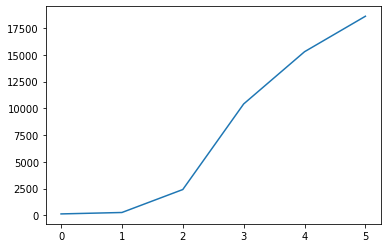

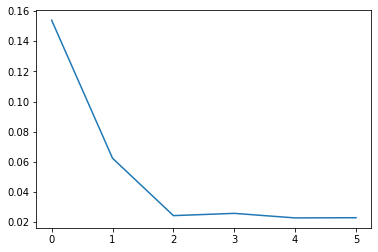

In [61]:
# acc_nnddsc, acc_ddddsc = sc.get_accuracy_plot()
# for acc in acc_ddddsc:
#     print(acc[1])
# res = list(zip(*acc_ddddsc)) 
# plt.plot(res[1])
err_nnddsc, err_ddddsc = sc.get_error_plot()
res_err = list(zip(*err_ddddsc)) 
plt.plot(res_err[0])
plt.show()

acc_nnsc, acc_ddsc = sc.get_accuracy_plot()
res_acc = list(zip(*acc_ddsc)) 
plt.plot(res_acc[0])
plt.show()
# err_nnddsc, err_ddddsc = sc.get_error_plot()


# # plotting acc/err
# # a_nnsc, a_ddsc = sc.get_a()
# # b_nnsc, b_ddsc = sc.get_b()
# # error, error_star = sc.error(list(x_train.values()),train_sum,B_list,A_list)
# # print("error: %s, error_star: %s" % (sum(error),sum(error_star)))

# for error, error_star in err_ddddsc:
#     print(sum(error.value()))
# # print(err_ddddsc)

In [ ]:
x_predict = sc.predict(A_last,B_list)
print("the shape of the first predicted appliances is :%s" %(np.asarray(list(x_predict)[0]).shape,))

In [ ]:
x_train.keys()

In [ ]:
#x_predict = sc.predict(A_last,B_list)
x_predict = sc.predict(A_list,B_list)

print(np.asarray(list(x_predict)[0])[0:,house])

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('classic')
# row and column sharing
house = 10

pie_chart_true = []
pie_chart_pred = []

f, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(6, 1, sharex='col', sharey='row', figsize=(16,12))
x = range(x_train[list(x_train.keys())[0]].shape[0])
plt.rcParams.update({'font.size': 15})


#===========whole home============
y_use_true = np.asarray(x_test_use)[0:,house]
ax1.plot(x, y_use_true, color='b',label='Actual energy')
y_use_pred = [-1]*x_train[list(x_train.keys())[0]].shape[0]
ax1.plot(x, y_use_pred, color='r', label='Predicted')
ax1.set_ylim([0,7])
ax1.set_ylabel('Whole Home')
ax1.legend()

#===========regrigerator============
y_ref_true = np.asarray(x_test[list(x_test.keys())[0]])[0:,house]
ax2.plot(x, y_ref_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_ref_pred = np.asarray(list(x_predict)[0])[0:,house]
ax2.plot(x, y_ref_pred, color='r')
#ax2.get_yaxis().set_visible(False)
ax2.set_ylabel('Refrigerator')
ax2.set_ylim([0,0.05])


#===========dishwasher============
y_dish_true = np.asarray(x_test[list(x_test.keys())[1]])[0:,house]
ax3.plot(x, y_dish_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_dish_pred = np.asarray(list(x_predict)[1])[0:,house]
ax3.plot(x,y_dish_pred, color='r')
#ax3.get_yaxis().set_visible(False)
ax3.set_ylabel('Dishwasher')
#ax3.set_ylim(-0.00001)

#===========furnace============
y_fur_true = np.asarray(x_test[list(x_test.keys())[2]])[0:,house]
ax4.plot(x, y_fur_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_fur_pred = np.asarray(list(x_predict)[2])[0:,house]
ax4.plot(x,y_fur_pred, color='r')
#ax4.get_yaxis().set_visible(False)
ax4.set_ylabel('Furnace')
# ax4.set_ylim(-0.05, 0.05)

#===========Air============
y_air_true = np.asarray(x_test[list(x_test.keys())[3]])[0:,house]
ax5.plot(x, y_air_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_air_pred = np.asarray(list(x_predict)[3])[0:,house]
ax5.plot(x, y_air_pred, color='r')
#ax5.get_yaxis().set_visible(False)
ax5.set_ylabel('Air')
# ax5.set_xlabel('Hours')

#===========others============
y_other_true = np.asarray(x_test[list(x_test.keys())[4]])[0:,house]
ax6.plot(x, y_other_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_other_pred = np.asarray(list(x_predict)[4])[0:,house]
ax6.plot(x, y_other_pred, color='r')
#ax5.get_yaxis().set_visible(False)
ax6.set_ylabel('Others')
ax6.set_xlabel('Hours')

In [ ]:
pie_chart_true = [y_ref_true.sum(), y_dish_true.sum(), y_fur_true.sum(), y_air_true.sum(), y_other_true.sum()]
pie_chart_pred = [y_ref_pred.sum(), y_dish_pred.sum(), y_fur_pred.sum(), y_air_pred.sum(), y_other_pred.sum()]

plt.style.use('classic')

def pie_chart(subplot, pie_chart, labels):
    # The slices will be ordered and plotted counter-clockwise.
    ## --- Plotting the true-piechart
    pie_chart_sum = sum(pie_chart)
    pie_chart = list(map(lambda x: x/pie_chart_sum,pie_chart))
    cmap = plt.cm.prism
    colors = cmap(np.linspace(0., 1., len(pie_chart)))
    pie_wedge_collection = subplot.pie(pie_chart, colors=colors, labels=labels, labeldistance=1.03)

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    
    
f, ((axes1, axes2)) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16,16))

labels = x_test.keys()
print(labels)
pie_chart(axes1,pie_chart_true,labels)
axes1.set_title('True usage')
pie_chart(axes2,pie_chart_pred,labels)
axes2.set_title('Predicted usage')
# axes2.text(0.95, 0.01, 'Accuracy of ' + str(round(sc.acc[0],1)), verticalalignment='center', horizontalalignment='right', transform=axes2.transAxes, color='black', fontsize=45)

## Statistical Analysis 

## Plotting the B matrices (basis functions)

In [ ]:
from matplotlib import cm

plt.figure(figsize=(16,12))

# row and column sharing
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,12))
plt.rcParams.update({'font.size': 15})


B_list[0] = B_list[0]/np.sum(B_list[0],axis=1)[:,None]  # Normalize
ax1.pcolor(B_list[0], cmap = cm.Greys_r)
B_list[1] = B_list[1]/np.sum(B_list[1],axis=1)[:,None]  # Normalize
ax2.pcolor(B_list[1], cmap = cm.Greys_r)
B_list[2] = B_list[2]/np.sum(B_list[2],axis=1)[:,None]  # Normalize
ax3.pcolor(B_list[2], cmap = cm.Greys_r)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

# plt.savefig(figure_directory+'basis')

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('classic')

# row and column sharing
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,12))
plt.rcParams.update({'font.size': 15})


for base in range(7):
    ax1.plot(range(n),B_list[0][base,0:])
    ax2.plot(range(n),B_list[1][base,0:])
    ax3.plot(range(n),B_list[2][base,0:])

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax1.set_ylim([0,0.04])
ax1.set_ylabel('Refrigerator')
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax2.set_ylim([0,0.06])
ax2.set_ylabel('Dishwasher')
ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax3.set_ylim([0,0.02])
ax3.set_ylabel('Furnace')